# Olfactory Game Mechanics Analysis
This notebook replicates and explains the analyses reported in the manuscript.

## 1. Setup and Preprocessing

In [4]:
# --- 1. Load and Preprocess Data ---
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
import matplotlib.colors as mcolors
from kneed import KneeLocator

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from IPython.display import display
import pandas as pd
import re

# File paths
video_games_path = './Data/Video_Games_2025-04-14.csv'
tabletop_games_path = './Data/Tabletop_Games_2025-03-29.csv'
other_games_path = './Data/Other_Games_2025-04-04.csv'
olfactory_games_path = './Data/Olfactory_Games_2025-04-14b.csv'
mechanics_path = './Data/Mechanics_2025-04-14.csv'

# Load and label source
video_games_df = pd.read_csv(video_games_path, usecols=['Game Title', 'Mechanics', 'Year'])
video_games_df['Source'] = 'Non-Olfactory'

tabletop_games_df = pd.read_csv(tabletop_games_path, usecols=['Game Title', 'Mechanics', 'Year'])
tabletop_games_df['Source'] = 'Non-Olfactory'

other_games_df = pd.read_csv(other_games_path, usecols=['Game Title', 'Mechanics', 'Year'])
other_games_df['Source'] = 'Non-Olfactory'

olfactory_games_df = pd.read_csv(olfactory_games_path, usecols=['Game Title', 'Mechanics', 'Year'])
olfactory_games_df['Source'] = 'Olfactory'

# Concatenate and filter
games_df = pd.concat([video_games_df, tabletop_games_df, other_games_df, olfactory_games_df]).drop_duplicates().reset_index(drop=True)
games_df = games_df[games_df['Mechanics'].notna() & (games_df['Mechanics'].str.strip() != '')]

# Standardize mechanics
mechanics_df = pd.read_csv(mechanics_path)
mechanic_mapping = {}
for _, row in mechanics_df.iterrows():
    canonical = row['Mechanic']
    synonyms = str(row['Synonyms']).split(', ') if pd.notna(row['Synonyms']) else []
    for synonym in synonyms + [canonical]:
        mechanic_mapping[synonym] = canonical

games_df['Standardized Mechanics'] = games_df['Mechanics'].apply(
    lambda x: list(set(mechanic_mapping.get(m, m) for m in str(x).split(', ')))
)

# --- 2. Create Binary Matrix ---
all_mechanics = sorted(set(mech for mechs in games_df['Standardized Mechanics'] for mech in mechs))
binary_matrix = pd.DataFrame(0, index=games_df['Game Title'] + ' (' + games_df.index.astype(str) + ')', columns=all_mechanics)
for _, game in games_df.iterrows():
    for mechanic in game['Standardized Mechanics']:
        binary_matrix.loc[game['Game Title'] + ' (' + str(game.name) + ')', mechanic] = 1

# --- 3. PCA and Variance Explained ---
pca = PCA()
game_embeddings_pca = pca.fit_transform(binary_matrix)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_90 = np.argmax(cumulative_variance >= 0.85) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

# print("Explained variance by each principal component:")
# for i, var in enumerate(explained_variance):
#     print(f"PCA Component {i+1}: {var:.2%}")
print(f"Number of components accounting for 90% variance: {n_components_90}")

# --- 4. Determine Optimal k (Clustering) ---
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(game_embeddings_pca[:, :n_components_90])
    wcss.append(kmeans_temp.inertia_)

knee_locator = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee


Number of components accounting for 90% variance: 18


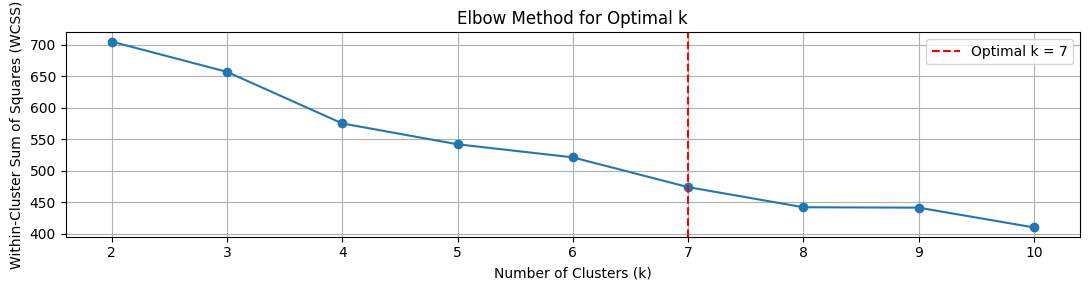

In [5]:

# Plot elbow with vertical line at optimal k
plt.figure(figsize=(11, 3))
plt.plot(k_range, wcss, marker='o')
if optimal_k:
    plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./Plots/Elbow_Method.png')
plt.show()

# Results
We present our findings in four stages: (1) descriptive patterns in players and scents; (2) frequency comparisons of mechanics across game types; (3) diversity analysis of mechanics within and across games; and (4) cluster-based exploration of mechanic groupings and their interpretive significance.

## 1. Descriptive Patterns in Players and Scents
### 1.2. Number of Players and Scents, Flexibility
On average, olfactory games supported approximately two players (M = 1.99, SD = 1.57; n = 155) and featured nearly ten distinct smells (M = 9.77, SD = 12.72; n = 137). See Figure 4 for distributions of the number of players and smells on average.

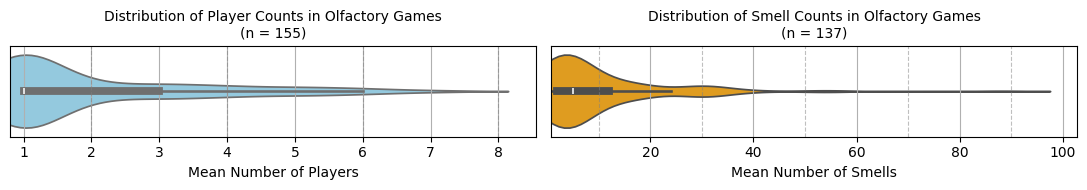

In [6]:
# --- Analyze Players and Smells in Olfactory Games (Filtered) ---

# Load olfactory game data
olfactory_df = pd.read_csv(olfactory_games_path)

# Helper: compute mean with fallback if max is missing/invalid
def compute_mean_range(min_val, max_val):
    try:
        min_val = float(min_val)
    except:
        return np.nan
    try:
        max_val = float(max_val)
    except:
        max_val = min_val
    return (min_val + max_val) / 2

# Compute mean players and smells
olfactory_df['Mean Players'] = olfactory_df.apply(lambda row: compute_mean_range(row['Players Min'], row['Players Max']), axis=1)
olfactory_df['Mean Smells'] = olfactory_df.apply(lambda row: compute_mean_range(row['Smells Min'], row['Smells Max']), axis=1)

# Filter out 0 or NaN values
valid_players_df = olfactory_df[olfactory_df['Mean Players'] > 0]
valid_smells_df = olfactory_df[olfactory_df['Mean Smells'] > 0]

# Count valid entries
valid_players_n = len(valid_players_df)
valid_smells_n = len(valid_smells_df)

# --- Combined Violin Plot for Players and Smells ---
fig, axes = plt.subplots(1, 2, figsize=(11, 2), sharey=False)

# --- Plot Mean Players ---
sns.violinplot(ax=axes[0], data=valid_players_df, x='Mean Players', orient='h',
               inner='box', color='skyblue')
axes[0].set_xlabel('Mean Number of Players')
axes[0].set_xlim(left=0.8)
axes[0].set_yticks([])  # Removes y-axis ticks
axes[0].set_title(f'Distribution of Player Counts in Olfactory Games\n(n = {valid_players_n})', fontsize=10)
axes[0].grid(True)

# Optional: add reference lines if you expect player counts of 2, 4, 6, etc.
for val in [2, 4, 6, 8, 10]:
    axes[0].axvline(val, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# --- Plot Mean Smells ---
sns.violinplot(ax=axes[1], data=valid_smells_df, x='Mean Smells', orient='h',
               inner='box', color='orange')
axes[1].set_xlabel('Mean Number of Smells')
axes[1].set_xlim(left=0.8)
axes[1].set_yticks([])  # Removes y-axis ticks
axes[1].set_title(f'Distribution of Smell Counts in Olfactory Games\n(n = {valid_smells_n})', fontsize=10)
axes[1].grid(True)

# Add dashed vertical lines at meaningful smell counts
for val in [10, 30, 50, 70, 90]:
    axes[1].axvline(val, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# --- Final layout and render ---
plt.tight_layout()
plt.savefig('./Plots/Figure04_Olfactory-Games-Players-Smells.png', dpi=300)
plt.show()

**Figure 4: Distribution of players and smell counts across olfactory games.** Violin plots showing the distribution of (left) mean number of players (n = 155 and (right) mean number of smells (n = 137) in olfactory games. While most olfactory games are designed for small groups, the number of smells varies considerably across games, with several titles supporting over 50 distinct olfactory elements.

The specificity of smells (defined by how precisely a given odor needs to be matched) was generally low (M = 1.01 on a 5-point scale, SD = 1.27; n = 205). In terms of how flexible the number of included smells could be, most games (74.0%) were classified as Fully Flexible (n = 152), meaning that the number of smells could be freely adjusted. A smaller portion were Expandable Only (11.8%; n = 24) or Fixed (14.2%; n = 29), where smell counts were constrained by core game elements. See Figure 5 for the distribution of smell specificity ratings and the smell flexibility counts.

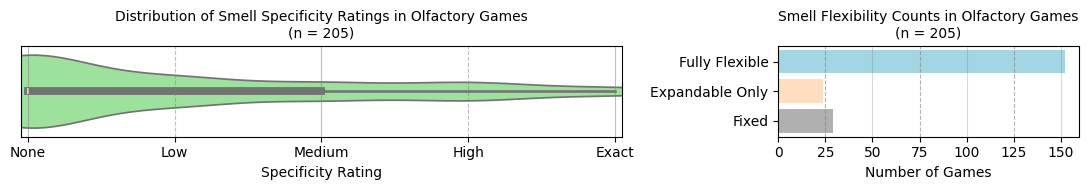

In [7]:
olfactory_df = pd.read_csv(olfactory_games_path, keep_default_na=False)

# --- Map Swappability Anchors to Likert Scale ---
swappability_map = {
    "None": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Exact": 4
}
swappability_labels = ['None', 'Low', 'Medium', 'High', 'Exact']

# Drop missing and map anchors
valid_swappability_df = olfactory_df[olfactory_df['Smell Specificity (Swappability)'].notna()].copy()
valid_swappability_df['Swappability Score'] = valid_swappability_df['Smell Specificity (Swappability)'].map(swappability_map)
valid_swappability_df = valid_swappability_df[valid_swappability_df['Swappability Score'].notna()]
swappability_n = len(valid_swappability_df)

# --- Prepare Flexibility Data (Filter out NaN and empty strings) ---
valid_flexibility_df = olfactory_df[
    olfactory_df['Smell Count Flexibility'].notna() & 
    (olfactory_df['Smell Count Flexibility'].str.strip() != '')
].copy()
flexibility_n = len(valid_flexibility_df)

# Custom category order and colors
custom_order = ['Fully Flexible', 'Expandable Only', 'Fixed']
flexibility_counts = valid_flexibility_df['Smell Count Flexibility'].value_counts().reindex(custom_order)

# Custom soft colors, gray for "Fixed"
flex_colors = ['#A1D6E2', '#FFDDC1', '#B0B0B0']  # pastel blue, peach, soft gray


# --- Plot Both in One Figure ---
fig, axes = plt.subplots(1, 2, figsize=(11, 2), gridspec_kw={'width_ratios': [2, 1]})

# --- Plot Swappability Violin ---
sns.violinplot(
    ax=axes[0],
    data=valid_swappability_df,
    x='Swappability Score',
    inner='box',
    color='lightgreen'
)
axes[0].set_title(f'Distribution of Smell Specificity Ratings in Olfactory Games\n(n = {swappability_n})', fontsize=10)
axes[0].set_ylabel(None)
axes[0].set_xlabel('Specificity Rating')
axes[0].set_xticks(range(5))
axes[0].set_yticks([])  # Removes y-axis ticks
axes[0].set_xticklabels(swappability_labels)
axes[0].set_xlim(-0.05, 4.05)
axes[0].grid(True, axis='y')

# Add vertical lines at key Likert boundaries
for x in [0, 2, 4]:
    axes[0].axvline(x, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)
for x in [1, 3]:
    axes[0].axvline(x, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# --- Plot Flexibility Bar Chart ---
axes[1].barh(flexibility_counts.index, flexibility_counts.values, color=flex_colors)
axes[1].set_title(f'Smell Flexibility Counts in Olfactory Games\n(n = {flexibility_n})', fontsize=10)
axes[1].set_xlabel('Number of Games')
axes[1].invert_yaxis()  # Puts "Fully Flexible" on top

# Add dashed reference lines at 25, 75, 125
for x in [25, 75, 125]:
    axes[1].axvline(x, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

# Manually add solid gridlines at 50, 100, 150
for x in [50, 100, 150]:
    axes[1].axvline(x, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)

# Optional: disable default x-axis grid to avoid duplication
axes[1].grid(False, axis='x')

# --- Final layout ---
plt.tight_layout()
plt.savefig('./Plots/Figure05_Olfactory-Specificity-Flexibility.png', dpi=300)
plt.show()

**Figure 5: Olfactory design constraints in games: specificity and flexibility.** Left: Distribution of smell specificity ratings (n = 205), where higher values indicate greater scent-to-gameplay correspondence (e.g., "Exact" denotes specific scents required). Right: Frequency of different smell count flexibility categories (n = 205), showing whether the number of scents is fixed, expandable, or fully customizable. Most olfactory games support flexible or expandable smell sets rather than fixed counts.

In [8]:
# Players
mean_players = valid_players_df['Mean Players'].mean()
sd_players = valid_players_df['Mean Players'].std()

# Smells
mean_smells = valid_smells_df['Mean Smells'].mean()
sd_smells = valid_smells_df['Mean Smells'].std()

# Swappability
mean_swappability = valid_swappability_df['Swappability Score'].mean()
sd_swappability = valid_swappability_df['Swappability Score'].std()

# Flexibility counts
flexibility_counts = valid_flexibility_df['Smell Count Flexibility'].value_counts().reindex(custom_order)

# --- Print Results ---
print(f"Mean Number of Players: M = {mean_players:.2f}, SD = {sd_players:.2f} (n = {valid_players_n})")
print(f"Mean Number of Smells: M = {mean_smells:.2f}, SD = {sd_smells:.2f} (n = {valid_smells_n})")
print(f"Swappability Rating: M = {mean_swappability:.2f}, SD = {sd_swappability:.2f} (n = {swappability_n})")
print("\nSmell Count Flexibility (n = {}):".format(flexibility_n))
for category, count in flexibility_counts.items():
    print(f"  {category}: {count}")

Mean Number of Players: M = 1.99, SD = 1.57 (n = 155)
Mean Number of Smells: M = 9.77, SD = 12.72 (n = 137)
Swappability Rating: M = 1.00, SD = 1.27 (n = 205)

Smell Count Flexibility (n = 205):
  Fully Flexible: 152
  Expandable Only: 24
  Fixed: 29


### 2.2 Top Smells
To identify the most frequently referenced smells in the dataset, we extracted comma-separated scent terms from two sources: the _Smells_ and _Example Smells_ fields in olfactory games (n = 141), and the _Smell(s) Mentioned_ field in all other games (n = 267). Entries were lowercased, stripped of punctuation, tokenized into individual words, and lemmatized to normalize inflectional variants (e.g., “roses” → “rose”). To avoid redundancy, common stop words and overlapping variants (e.g., “skunk” vs. “skunk spray”) were manually filtered out prior to analysis. Additionally, to avoid repetition from sources with slight variations (e.g., multiple dragon smells), each game could contribute a given term only once.

To account for differences in sample size and scent richness across game types, we employed a rarefied bootstrapping procedure. Specifically, we sampled 130 games from each group without replacement across 2,000 iterations. In each iteration, we extracted unique terms, ranked them by frequency, and recorded their position if they appeared in the top 10. This produced a distribution of ranks for each smell term, allowing us to compute: mean rank (μ) across bootstraps, 95% confidence intervals (CIs) via percentiles, and percentage of iterations in which a term appeared in the top 10.

Table 1 and Figure 6 present the top 10 smells referenced in olfactory and non-olfactory games. The top smell terms in olfactory games exhibited high frequency and rank stability. For instance, orange consistently ranked first (μ = 1.11, SD = 0.36, 95% CI [1.00, 2.00]) and appeared in 100% of bootstraps. Mint (μ = 2.41, SD = 0.80, 95% CI [1.00, 4.00]) and rose (μ = 3.27, SD = 0.79, 95% CI [2.00, 5.00]) followed with similarly tight confidence intervals. These results reflect a high degree of olfactory cohesion in the olfactory game dataset, with pleasant, food- and nature-related smells dominating the top ranks.

In contrast, non-olfactory games were dominated by pungent, bodily, or affectively charged terms such as fart (μ = 1.00, 95% CI [1.00, 1.00]), skunk (μ = 2.07, 95% CI [2.00, 3.00]), pheromone (μ = 3.82, 95% CI [3.00, 6.00]), pepper (μ = 3.83, 95% CI [3.00, 6.00]), and breath (μ = 4.59, 95% CI [3.00, 7.00]). While these terms also showed high frequency and consistency, lower-ranked terms like meat and human exhibited much wider confidence intervals and lower appearance rates, indicating more olfactory dispersion in how smell is referenced across these games.

In [9]:
# --- Parameters ---
n_iterations = 2500
top_n = 10
top_k_for_plot = 10  # Number of smells to plot

# --- Initialize ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# --- Load data ---
olfactory_raw = pd.read_csv(olfactory_games_path, usecols=['Smells', 'Example Smells'])
nonolfactory_raw = pd.concat([
    pd.read_csv(video_games_path, usecols=['Fragrance(s) Mentioned']),
    pd.read_csv(tabletop_games_path, usecols=['Fragrance(s) Mentioned']),
    pd.read_csv(other_games_path, usecols=['Fragrance(s) Mentioned'])
])

# --- Filter valid entries ---
olfactory_entries = olfactory_raw[
    olfactory_raw['Smells'].notna() | olfactory_raw['Example Smells'].notna()
].copy()
nonolfactory_entries = nonolfactory_raw[
    nonolfactory_raw['Fragrance(s) Mentioned'].notna()
].copy()

min_sample_size = min(len(olfactory_entries), len(nonolfactory_entries)) - 10
# --- Manual stop terms ---
manual_exclude = {'spray', 'stench', 'smell', 'odor', 'scent', 'bad', 'smelly', 'pleasant', 'unpleasant', 'foul'}

# --- Manual term mappings ---
manual_mappings = {
    'peppermint': 'mint',
    'breath mint': 'mint',
    'breath mints': 'mint',
    'minty': 'mint',
    'lavendar': 'lavender'  # Example: typo correction
}

# --- Helper: extract, map, lemmatize, and tokenize (deduplicated per game) ---
def extract_unique_smells_per_game(df, fields):
    game_terms = []
    for _, row in df.iterrows():
        combined_text = ' '.join(str(row[field]).lower() for field in fields if pd.notna(row[field]))
        
        # Manual mappings first
        detected_terms = set()
        for phrase, mapped in manual_mappings.items():
            if phrase in combined_text:
                detected_terms.add(mapped)
                combined_text = combined_text.replace(phrase, '')  # prevent double count

        # Tokenize remaining text
        for raw_smell in combined_text.split(','):
            smell = raw_smell.strip()
            smell = re.sub(r'[^a-zA-Z\s\-]', '', smell)
            tokens = smell.split()
            lemmatized = {
                lemmatizer.lemmatize(t)
                for t in tokens
                if t not in stop_words and t not in manual_exclude
            }
            detected_terms.update(lemmatized)

        game_terms.append(list(detected_terms))
    return game_terms

# --- Bootstrapping with deduplicated terms per game ---
def get_top_terms_with_ranks(df, fields, n_samples):
    term_ranks = defaultdict(list)
    preprocessed_game_terms = extract_unique_smells_per_game(df, fields)

    for _ in range(n_iterations):
        sampled_idxs = np.random.choice(len(preprocessed_game_terms), n_samples, replace=False)
        terms_flat = [term for idx in sampled_idxs for term in preprocessed_game_terms[idx]]
        top_terms = [term for term, _ in Counter(terms_flat).most_common(top_n)]
        for rank, term in enumerate(top_terms, start=1):
            term_ranks[term].append(rank)

    # Summarize results
    summary = []
    for term, ranks in sorted(term_ranks.items(), key=lambda x: np.mean(x[1])):
        ranks_arr = np.array(ranks)
        summary.append({
            'Smell': term,
            'Appearances': len(ranks),
            'Mean Rank': np.mean(ranks_arr),
            '95% CI': f"[{np.percentile(ranks_arr, 2.5):.2f}, {np.percentile(ranks_arr, 97.5):.2f}]",
            'Pct Appearances': f"{(len(ranks_arr)/n_iterations)*100:.1f}%"
        })
    return pd.DataFrame(summary).sort_values(by='Mean Rank').head(top_n), term_ranks

# --- Run rarefied bootstraps ---
olf_summary, olf_ranks = get_top_terms_with_ranks(olfactory_entries, ['Smells', 'Example Smells'], min_sample_size)
nonolf_summary, nonolf_ranks = get_top_terms_with_ranks(nonolfactory_entries, ['Fragrance(s) Mentioned'], min_sample_size)

# --- Expanded Format Result Table with All Relevant Measures ---
summary_table = pd.DataFrame({
    'Rank': range(1, top_n + 1),
    
    'Olfactory Term': [row['Smell'] for _, row in olf_summary.iterrows()],
    'Olfactory μ': [f"{row['Mean Rank']:.2f}" for _, row in olf_summary.iterrows()],
    'Olfactory 95% CI': [row['95% CI'] for _, row in olf_summary.iterrows()],
    'Olfactory % Appeared': [row['Pct Appearances'] for _, row in olf_summary.iterrows()],
    
    'Non-Olfactory Term': [row['Smell'] for _, row in nonolf_summary.iterrows()],
    'Non-Olfactory μ': [f"{row['Mean Rank']:.2f}" for _, row in nonolf_summary.iterrows()],
    'Non-Olfactory 95% CI': [row['95% CI'] for _, row in nonolf_summary.iterrows()],
    'Non-Olfactory % Appeared': [row['Pct Appearances'] for _, row in nonolf_summary.iterrows()]
})

display(summary_table)

# --- Reformatted Result Table with M, SD, CI Style ---
summary_table_paper = pd.DataFrame({
    'Rank': range(1, top_n + 1),
    'Olfactory': [
        f"{row['Smell']} (M = {row['Mean Rank']:.2f}, SD = {np.std(olf_ranks[row['Smell']]):.2f}, 95% CI {row['95% CI']})"
        for _, row in olf_summary.iterrows()
    ],
    'Non-Olfactory': [
        f"{row['Smell']} (M = {row['Mean Rank']:.2f}, SD = {np.std(nonolf_ranks[row['Smell']]):.2f}, 95% CI {row['95% CI']})"
        for _, row in nonolf_summary.iterrows()
    ]
})

display(summary_table_paper)

,Rank,Olfactory Term,Olfactory μ,Olfactory 95% CI,Olfactory % Appeared,Non-Olfactory Term,Non-Olfactory μ,Non-Olfactory 95% CI,Non-Olfactory % Appeared
0,1,orange,1.12,"[1.00, 2.00]",100.0%,fart,1.00,"[1.00, 1.00]",100.0%
1,2,mint,2.43,"[1.00, 4.00]",100.0%,skunk,2.10,"[2.00, 3.00]",100.0%
2,3,apple,3.21,"[2.00, 5.00]",100.0%,pepper,3.80,"[2.00, 6.00]",99.7%
3,4,rose,3.34,"[2.00, 5.00]",100.0%,pheromone,3.82,"[2.00, 6.00]",99.7%
4,5,lemon,5.53,"[4.00, 7.00]",100.0%,breath,4.58,"[3.00, 7.00]",98.6%
5,6,cinnamon,5.61,"[4.00, 7.00]",100.0%,stink,7.14,"[5.00, 10.00]",65.4%
6,7,banana,7.09,"[6.00, 8.00]",100.0%,gas,7.16,"[5.00, 10.00]",65.0%
7,8,strawberry,7.83,"[7.00, 9.00]",100.0%,food,7.56,"[5.00, 10.00]",49.8%
8,9,chocolate,8.88,"[7.48, 10.00]",100.0%,human,7.58,"[5.00, 10.00]",48.5%
9,10,grass,9.97,"[9.00, 10.00]",99.8%,meat,7.66,"[5.00, 10.00]",49.0%


,Rank,Olfactory,Non-Olfactory
0,1,"orange (M = 1.12, SD = 0.40, 95% CI [1.00, 2.00])","fart (M = 1.00, SD = 0.00, 95% CI [1.00, 1.00])"
1,2,"mint (M = 2.43, SD = 0.80, 95% CI [1.00, 4.00])","skunk (M = 2.10, SD = 0.38, 95% CI [2.00, 3.00])"
2,3,"apple (M = 3.21, SD = 0.87, 95% CI [2.00, 5.00])","pepper (M = 3.80, SD = 1.00, 95% CI [2.00, 6.00])"
3,4,"rose (M = 3.34, SD = 0.83, 95% CI [2.00, 5.00])","pheromone (M = 3.82, SD = 0.99, 95% CI [2.00, ..."
4,5,"lemon (M = 5.53, SD = 0.79, 95% CI [4.00, 7.00])","breath (M = 4.58, SD = 1.10, 95% CI [3.00, 7.00])"
5,6,"cinnamon (M = 5.61, SD = 0.73, 95% CI [4.00, 7...","stink (M = 7.14, SD = 1.45, 95% CI [5.00, 10.00])"
6,7,"banana (M = 7.09, SD = 0.72, 95% CI [6.00, 8.00])","gas (M = 7.16, SD = 1.46, 95% CI [5.00, 10.00])"
7,8,"strawberry (M = 7.83, SD = 0.61, 95% CI [7.00,...","food (M = 7.56, SD = 1.41, 95% CI [5.00, 10.00])"
8,9,"chocolate (M = 8.88, SD = 0.47, 95% CI [7.48, ...","human (M = 7.58, SD = 1.44, 95% CI [5.00, 10.00])"
9,10,"grass (M = 9.97, SD = 0.17, 95% CI [9.00, 10.00])","meat (M = 7.66, SD = 1.44, 95% CI [5.00, 10.00])"


**Table 1: Top 10 most frequently referenced smells in olfactory and non-olfactory games based on bootstrapped rarefied rank analysis.** Groups were rarefied to equal sample sizes (n = 132) and iteratively resampled 2,500 times without replacement. The table reports the mean rank (± standard deviation), 95% confidence interval of ranks, and percentage of iterations in which each smell appeared in the top 10.

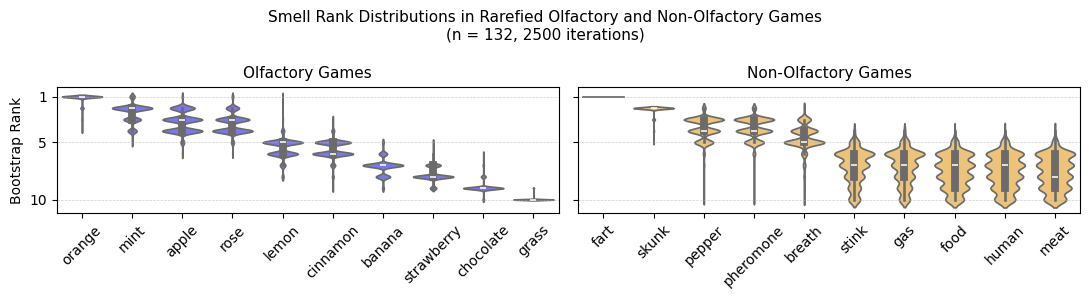

Rarefied to 132 games from each group (olfactory & non-olfactory)
Original olfactory entries: 142
Original non-olfactory entries: 267


In [10]:
def plot_rank_distributions_side_by_side(olf_ranks_dict, nonolf_ranks_dict, top_k, save_path=None, n_olf=None, n_nonolf=None):
    def prepare_data(term_ranks, group_label):
        sorted_terms = sorted(
            term_ranks.items(), key=lambda x: np.mean(x[1])
        )[:top_k]
        top_terms = [term for term, _ in sorted_terms]
        return pd.DataFrame([
            {'Smell': term, 'Rank': rank, 'Group': group_label}
            for term in top_terms
            for rank in term_ranks[term]
        ])

    olf_df = prepare_data(olf_ranks_dict, 'Olfactory')
    nonolf_df = prepare_data(nonolf_ranks_dict, 'Non-Olfactory')

    fig, axes = plt.subplots(1, 2, figsize=(11, 3), sharey=True)

    # Olfactory plot
    olf_palette = ['#6666ff'] * top_k
    sns.violinplot(
        data=olf_df,
        x='Smell', y='Rank', hue='Smell',
        palette=dict(zip(olf_df['Smell'].unique(), olf_palette)),
        ax=axes[0], legend=False
    )
    fig.suptitle(f'Smell Rank Distributions in Rarefied Olfactory and Non-Olfactory Games\n(n = {min_sample_size}, {n_iterations} iterations)', fontsize=11)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Bootstrap Rank')
    axes[0].tick_params(axis='x', rotation=45)

    # Non-Olfactory plot
    nonolf_palette = ['#ffc966'] * top_k
    sns.violinplot(
        data=nonolf_df,
        x='Smell', y='Rank', hue='Smell',
        palette=dict(zip(nonolf_df['Smell'].unique(), nonolf_palette)),
        ax=axes[1], legend=False
    )
    # Set simpler per-panel titles
    axes[0].set_title('Olfactory Games', fontsize=11)
    axes[1].set_title('Non-Olfactory Games', fontsize=11)
    # axes[1].invert_yaxis()
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', rotation=45)

    for ax in axes:
        ax.set_yticks([1, 5, 10])
        ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)


    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



# Call the updated function
plot_rank_distributions_side_by_side(
    olf_ranks,
    nonolf_ranks,
    top_k_for_plot,
    save_path='./Plots/Figure06_Smell-Rank-Distribution.png',
    n_olf=min_sample_size,
    n_nonolf=min_sample_size
)


# --- Info ---
print(f"Rarefied to {min_sample_size} games from each group (olfactory & non-olfactory)")
print(f"Original olfactory entries: {len(olfactory_entries)}")
print(f"Original non-olfactory entries: {len(nonolfactory_entries)}")

**Figure 6: Smell rank distributions in rarefied olfactory and non-olfactory games (n = 132 per group, 2,500 bootstrap iterations).** Violin plots show the bootstrap distribution of ranks for the 10 most frequently mentioned smells in each group. Lower ranks indicate more frequent and consistent mention across bootstraps. Olfactory games show tight, low-rank distributions, while non-olfactory games exhibit broader distributions for scents after the fifth rank (gas, stink, human, meat, and food).

## 2. Mechanics analysis
### 2.1. Frequency comparisons of mechanics across game types
A Chi-square analysis (adjusted for multiple comparisons using the Benjamini-Hochberg method) revealed significant differences between olfactory and non-olfactory games in the frequency of multiple mechanics (see Table 2). Non-olfactory games were characterized by mechanics such as Emanating, Damaging, Buffing, Reflexing, and Signaling (all padj < 0.001). In contrast, olfactory games significantly employed sensory-focused mechanics like Identifying, Matching, Memorizing, Labeling, Experiencing, Discriminating, Composing, and Rewarding (all padj  < 0.001).

In [11]:
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

# Add source labels back into the binary_matrix for grouping
binary_matrix['Source'] = games_df['Source'].values

# Create a copy with only mechanic (binary) columns
binary_numeric = binary_matrix.drop(columns=['Source', 'Cluster', 'Year'], errors='ignore')

# Group by 'Source' and sum mechanic usage
mechanic_counts = binary_numeric.groupby(binary_matrix['Source']).sum().T

# Clean up column names to avoid KeyErrors from whitespace
mechanic_counts.columns = mechanic_counts.columns.str.strip()

# Total games per category
total_olf = binary_matrix[binary_matrix['Source'] == 'Olfactory'].shape[0]
total_nonolf = binary_matrix[binary_matrix['Source'] == 'Non-Olfactory'].shape[0]

# Perform Chi-square tests
chi2_results = []
for mechanic in mechanic_counts.index:
    try:
        olf_count = mechanic_counts.loc[mechanic, 'Olfactory']
        nonolf_count = mechanic_counts.loc[mechanic, 'Non-Olfactory']
    except KeyError:
        continue  # Skip if one group is missing

    contingency_table = np.array([
        [olf_count, total_olf - olf_count],
        [nonolf_count, total_nonolf - nonolf_count]
    ])

    chi2, p, _, _ = chi2_contingency(contingency_table)

    olf_prop = olf_count / total_olf
    nonolf_prop = nonolf_count / total_nonolf
    more_common_in = 'Olfactory' if olf_prop > nonolf_prop else 'Non-Olfactory'

    chi2_results.append({
        'Mechanic': mechanic,
        'Olfactory_Count': olf_count,
        'NonOlfactory_Count': nonolf_count,
        'Olfactory_Proportion': olf_prop,
        'NonOlfactory_Proportion': nonolf_prop,
        'Chi2': chi2,
        'p-value': p,
        'More_Common_In': more_common_in
    })

# Compile results into a DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values('p-value')

# Adjust p-values for multiple comparisons (Benjamini-Hochberg)
chi2_df['p-adjusted'] = multipletests(chi2_df['p-value'], method='fdr_bh')[1]

# Save the full results
chi2_df.to_csv('./Tables/ChiSquare_Mechanics.csv', index=False)

# Display significant results
significant_mechanics = chi2_df[chi2_df['p-adjusted'] < 0.05]
print("Significant Chi-square Results (Olfactory vs. Non-Olfactory Mechanics):")
display(significant_mechanics)

Significant Chi-square Results (Olfactory vs. Non-Olfactory Mechanics):


,Mechanic,Olfactory_Count,NonOlfactory_Count,Olfactory_Proportion,NonOlfactory_Proportion,Chi2,p-value,More_Common_In,p-adjusted
10,Emanating,7,164,0.028571,0.581560,180.385324,3.992906e-41,Non-Olfactory,1.517304e-39
13,Identifying,128,34,0.522449,0.120567,97.573501,5.189377e-23,Olfactory,9.859816e-22
5,Damaging,3,97,0.012245,0.343972,91.688496,1.014530e-21,Non-Olfactory,1.285071e-20
2,Buffing,4,69,0.016327,0.244681,55.390628,9.880642e-14,Non-Olfactory,9.386609e-13
20,Matching,47,4,0.191837,0.014184,45.325277,1.668813e-11,Olfactory,1.268298e-10
21,Memorizing,37,3,0.151020,0.010638,34.860716,3.541549e-09,Olfactory,2.242981e-08
15,Labeling,26,0,0.106122,0.000000,29.257612,6.336681e-08,Olfactory,3.439913e-07
12,Experiencing,44,11,0.179592,0.039007,26.236651,3.020355e-07,Olfactory,1.434668e-06
31,Reflexing,2,34,0.008163,0.120567,24.289772,8.287797e-07,Non-Olfactory,3.499292e-06
8,Discriminating,29,4,0.118367,0.014184,22.500120,2.101304e-06,Olfactory,7.984957e-06


In [12]:
# Helper function to convert a float p-value to a format like '9.89 × 10⁻³⁷'
def format_sci_unicode(x):
    if x == 0:
        return "0"
    base, exp = f"{x:.1e}".split("e")
    exp = int(exp)
    superscripts = str.maketrans("-0123456789", "⁻⁰¹²³⁴⁵⁶⁷⁸⁹")
    return f"{base} × 10{str(exp).translate(superscripts)}"

# Helper to assign significance stars
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Apply to significant results
significant_mechanics = chi2_df[chi2_df['p-adjusted'] < 0.05].copy()
significant_mechanics['Chi2'] = significant_mechanics['Chi2'].map(lambda x: f"{x:.2f}")
significant_mechanics['p-adjusted-formatted'] = significant_mechanics['p-adjusted'].map(format_sci_unicode)
significant_mechanics['Significance'] = chi2_df['p-adjusted'].map(significance_stars)

# Select and reorder columns
formatted_results = significant_mechanics[[
    'Mechanic', 'Olfactory_Count', 'NonOlfactory_Count', 'Chi2', 'p-adjusted-formatted', 'Significance'
]].rename(columns={'p-adjusted-formatted': 'p-adj'})

# Display nicely
print("Significant Chi-square Results (formatted for publication):")
display(formatted_results)

# Optional: Save to file
formatted_results.to_csv('./Tables/Table02_ChiSquare-Significant-Mechanics-Formatted.csv', index=False)


Significant Chi-square Results (formatted for publication):


,Mechanic,Olfactory_Count,NonOlfactory_Count,Chi2,p-adj,Significance
10,Emanating,7,164,180.39,1.5 × 10⁻³⁹,***
13,Identifying,128,34,97.57,9.9 × 10⁻²²,***
5,Damaging,3,97,91.69,1.3 × 10⁻²⁰,***
2,Buffing,4,69,55.39,9.4 × 10⁻¹³,***
20,Matching,47,4,45.33,1.3 × 10⁻¹⁰,***
21,Memorizing,37,3,34.86,2.2 × 10⁻⁸,***
15,Labeling,26,0,29.26,3.4 × 10⁻⁷,***
12,Experiencing,44,11,26.24,1.4 × 10⁻⁶,***
31,Reflexing,2,34,24.29,3.5 × 10⁻⁶,***
8,Discriminating,29,4,22.50,8.0 × 10⁻⁶,***


**Table 2: Chi-square analysis comparing the frequency of mechanics in olfactory vs. non-olfactory games.** Adjusted p-values (Benjamini-Hochberg correction) indicate which mechanics are significantly associated with each group. Mechanics are ordered by decreasing statistical significance.

(Significance: p < 0.001 = ✱✱✱, p < 0.01 = ✱✱, p < 0.05 = ✱.)

### 2.2. Mechanic diversity
To compare group-level mechanic diversity, we computed the Shannon diversity index for olfactory and non-olfactory games, treating all games in each group as a pooled set of mechanics. To control for unequal sample sizes, we conducted a rarefaction analysis by randomly subsampling both groups to a standardized size of 235 games. For each group, we drew 2,500 samples without replacement and computed the Shannon index across each subset (see Figure 7). Olfactory games exhibited significantly greater group-level mechanic diversity (M = 2.94, SD = 0.011, 95% CI [2.94, 2.94]) than non-olfactory games (M = 2.68, SD = 0.024, 95% CI [2.68, 2.69]), with a highly significant difference (p < 0.0001, Mann–Whitney U). The effect size was exceptionally large (Cohen’s d = 13.75), indicating that olfactory games consistently engage a broader and more diverse set of mechanics, even when controlling for sampling effort.

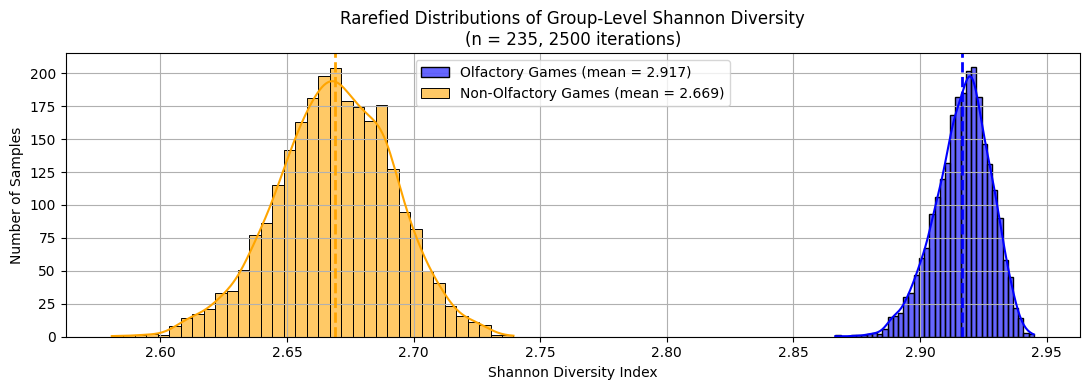

Rarefied Mann-Whitney U test p-value: 0.0000


In [13]:
from scipy.stats import entropy, mannwhitneyu

# Function to calculate Shannon diversity index
def shannon_diversity(matrix):
    # Ensure only numeric columns
    matrix = matrix.select_dtypes(include=[np.number])
    total = matrix.values.sum()
    if total == 0:
        return 0.0  # edge case: empty or all-zero matrix
    proportions = matrix.sum(axis=0) / total
    return entropy(proportions)

# Prepare mechanic-only matrices
drop_cols = ['Source', 'Cluster', 'Year']
olfactory_matrix = binary_matrix[binary_matrix['Source'] == 'Olfactory'].drop(columns=drop_cols, errors='ignore')
nonolfactory_matrix = binary_matrix[binary_matrix['Source'] == 'Non-Olfactory'].drop(columns=drop_cols, errors='ignore')

def rarefaction_shannon(matrix, n_samples, iterations=2500):
    indices = []
    for _ in range(iterations):
        sample = matrix.sample(n=n_samples, replace=False)
        indices.append(shannon_diversity(sample))
    return indices


# Re-run rarefaction with adjusted sample size
min_sample_size = min(olfactory_matrix.shape[0], nonolfactory_matrix.shape[0]) - 10
olf_rare = rarefaction_shannon(olfactory_matrix, min_sample_size)
nonolf_rare = rarefaction_shannon(nonolfactory_matrix, min_sample_size)

# Calculate means
mean_olf_rare = np.mean(olf_rare)
mean_nonolf_rare = np.mean(nonolf_rare)

# Plot rarefied distributions with mean lines
plt.figure(figsize=(11, 4))
sns.histplot(olf_rare, kde=True, color='blue', alpha=0.6, label=f'Olfactory Games (mean = {mean_olf_rare:.3f})')
sns.histplot(nonolf_rare, kde=True, color='orange', alpha=0.6, label=f'Non-Olfactory Games (mean = {mean_nonolf_rare:.3f})')
plt.axvline(mean_olf_rare, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_nonolf_rare, color='orange', linestyle='--', linewidth=2)

# Formatting
plt.title(f'Rarefied Distributions of Group-Level Shannon Diversity\n(n = {min_sample_size}, 2500 iterations)')
plt.xlabel('Shannon Diversity Index')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./Plots/Figure07_Rarefied-Shannon-Diversity-Distributions.png')
plt.show()

# Mann-Whitney U test
stat, p_val = mannwhitneyu(olf_rare, nonolf_rare)
print(f"Rarefied Mann-Whitney U test p-value: {p_val:.4f}")


**Figure 7: Distributions of Shannon diversity scores computed from rarefied subsets of games.** For each group, 2,500 random samples of equal size (n = 235 games) were drawn without replacement, and group-level Shannon diversity was computed for each subset. This approach controls for unequal sample sizes when comparing overall mechanic diversity between olfactory and non-olfactory games.

In [14]:
import numpy as np
import scipy.stats as stats
from statistics import mean, stdev

def summary_stats(data):
    n = len(data)
    m = mean(data)
    sd = stdev(data)
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=m, scale=sd/np.sqrt(n))
    return m, sd, (ci_low, ci_high), n

# Get summaries
mean_olf, sd_olf, ci_olf, n_olf = summary_stats(olf_rare)
mean_nonolf, sd_nonolf, ci_nonolf, n_nonolf = summary_stats(nonolf_rare)

# Cohen's d
cohen_d = (mean_olf - mean_nonolf) / np.sqrt((sd_olf**2 + sd_nonolf**2) / 2)

# Print results
print(f"Olfactory Shannon Diversity: M = {mean_olf:.4f}, SD = {sd_olf:.4f}, 95% CI = [{ci_olf[0]:.4f}, {ci_olf[1]:.4f}], n = {n_olf}")
print(f"Non-Olfactory Shannon Diversity: M = {mean_nonolf:.4f}, SD = {sd_nonolf:.4f}, 95% CI = [{ci_nonolf[0]:.4f}, {ci_nonolf[1]:.4f}], n = {n_nonolf}")
print(f"Cohen's d Effect Size: {cohen_d:.4f}")


Olfactory Shannon Diversity: M = 2.9167, SD = 0.0109, 95% CI = [2.9163, 2.9171], n = 2500
Non-Olfactory Shannon Diversity: M = 2.6689, SD = 0.0229, 95% CI = [2.6680, 2.6698], n = 2500
Cohen's d Effect Size: 13.7959


We next assessed per-game Shannon diversity, which measures the number and distribution of mechanics used within each individual game (see Figure 8). Non-olfactory games showed a higher average diversity (M = 0.79, SD = 0.42, 95% CI [0.74, 0.84], n = 282) than olfactory games (M = 0.69, SD = 0.48, 95% CI [0.63, 0.75], n = 245).

Shapiro–Wilk tests indicated that neither distribution was normal (ps < .0001), and a Kolmogorov–Smirnov test further confirmed a significant difference in distribution shape (p = 0.0219). However, a Mann–Whitney U test showed no significant difference (p = 0.0579) in per-game mechanic diversity between olfactory and non-olfactory games.

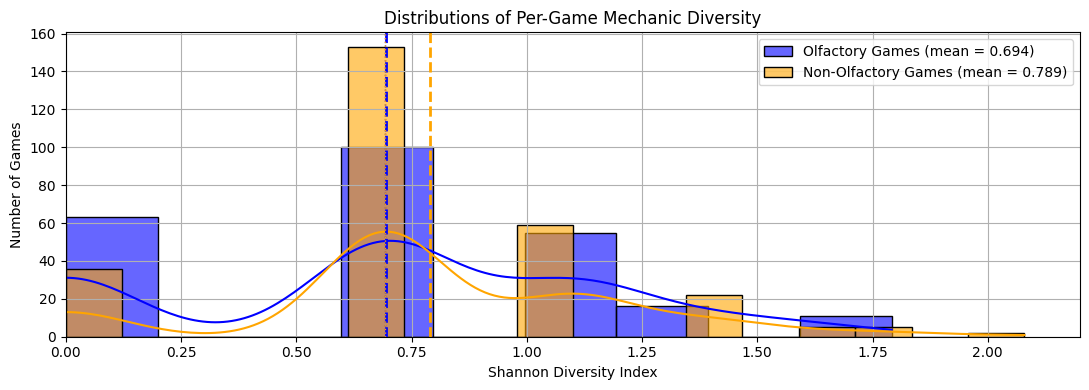

Per-game Shannon Diversity Mann-Whitney U p-value: 0.0661
❌ No significant difference in per-game mechanic diversity between olfactory and non-olfactory games.


In [15]:
# --- Per-Game Shannon Diversity Analysis ---

from scipy.stats import entropy, mannwhitneyu
import numpy as np

# Function to calculate Shannon diversity per game (row-wise)
def per_game_shannon(matrix):
    matrix = matrix.select_dtypes(include=[np.number])  # only mechanic columns
    return matrix.apply(lambda row: entropy(row.values), axis=1)

# Compute per-game Shannon diversity for each group
olfactory_game_diversity = per_game_shannon(olfactory_matrix)
nonolfactory_game_diversity = per_game_shannon(nonolfactory_matrix)

# Calculate means and medians
mean_olf = olfactory_game_diversity.mean()
mean_nonolf = nonolfactory_game_diversity.mean()
median_olf = olfactory_game_diversity.median()
median_nonolf = nonolfactory_game_diversity.median()

# Visualize distributions with KDE and summary stats
plt.figure(figsize=(11, 4))
sns.histplot(olfactory_game_diversity, color='blue', label=f'Olfactory Games (mean = {mean_olf:.3f})', kde=True, alpha=0.6)
sns.histplot(nonolfactory_game_diversity, color='orange', label=f'Non-Olfactory Games (mean = {mean_nonolf:.3f})', kde=True, alpha=0.6)

# Add vertical lines for means
plt.axvline(mean_olf, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_nonolf, color='orange', linestyle='--', linewidth=2)

# Optional: Add vertical lines for medians
plt.axvline(median_olf, color='blue', linestyle=':', linewidth=1)
plt.axvline(median_nonolf, color='orange', linestyle=':', linewidth=1)

# Formatting
plt.title('Distributions of Per-Game Mechanic Diversity')
plt.xlabel('Shannon Diversity Index')
plt.ylabel('Number of Games')
plt.legend()
plt.grid(True)
plt.xlim(0, 2.2)  # or plt.xlim(0, max_value + a little buffer)
plt.tight_layout()
plt.savefig('./Plots/Figure08_PerGame-Shannon-Diversity.png')
plt.show()

# Statistical test
stat, p_val_game = mannwhitneyu(olfactory_game_diversity, nonolfactory_game_diversity, alternative='two-sided')
print(f"Per-game Shannon Diversity Mann-Whitney U p-value: {p_val_game:.4f}")

if p_val_game < 0.05:
    print("✅ Significant difference in per-game mechanic diversity between olfactory and non-olfactory games.")
else:
    print("❌ No significant difference in per-game mechanic diversity between olfactory and non-olfactory games.")


**Figure 8: Distribution of per-game mechanic diversity, measured using Shannon diversity indices.** Each game's mechanics were treated as a probability distribution to compute a per-game Shannon index.

In [16]:
import numpy as np
from scipy.stats import shapiro, ks_2samp, t
from statistics import mean, stdev

# Function to get full summary stats
def summary_stats(data):
    data = data.dropna()
    n = len(data)
    m = mean(data)
    med = data.median()
    sd = stdev(data)
    ci_low, ci_high = t.interval(0.95, df=n-1, loc=m, scale=sd/np.sqrt(n))
    return {
        "mean": m,
        "median": med,
        "sd": sd,
        "ci": (ci_low, ci_high),
        "n": n
    }

# Compute stats for each group
stats_olf = summary_stats(olfactory_game_diversity)
stats_nonolf = summary_stats(nonolfactory_game_diversity)

# Shapiro-Wilk normality test
shapiro_olf = shapiro(olfactory_game_diversity)
shapiro_nonolf = shapiro(nonolfactory_game_diversity)

# Kolmogorov-Smirnov distribution test
ks_result = ks_2samp(olfactory_game_diversity, nonolfactory_game_diversity)

# Cliff’s delta
from cliffs_delta import cliffs_delta
delta, size = cliffs_delta(olfactory_game_diversity.tolist(), nonolfactory_game_diversity.tolist())

# Print results
print("Olfactory Per-Game Shannon Diversity:")
print(f"  Mean = {stats_olf['mean']:.4f}")
print(f"  Median = {stats_olf['median']:.4f}")
print(f"  SD = {stats_olf['sd']:.4f}")
print(f"  95% CI = [{stats_olf['ci'][0]:.4f}, {stats_olf['ci'][1]:.4f}]")
print(f"  n = {stats_olf['n']}")

print("\nNon-Olfactory Per-Game Shannon Diversity:")
print(f"  Mean = {stats_nonolf['mean']:.4f}")
print(f"  Median = {stats_nonolf['median']:.4f}")
print(f"  SD = {stats_nonolf['sd']:.4f}")
print(f"  95% CI = [{stats_nonolf['ci'][0]:.4f}, {stats_nonolf['ci'][1]:.4f}]")
print(f"  n = {stats_nonolf['n']}")

print("\nShapiro-Wilk Normality Test:")
print(f"  Olfactory: W = {shapiro_olf.statistic:.4f}, p = {shapiro_olf.pvalue:.2e}")
print(f"  Non-Olfactory: W = {shapiro_nonolf.statistic:.4f}, p = {shapiro_nonolf.pvalue:.2e}")

print("\nKolmogorov-Smirnov Test:")
print(f"  KS statistic = {ks_result.statistic:.4f}, p = {ks_result.pvalue:.4f}")

print(f"\nCliff’s delta: {delta:.4f} ({size} effect)")


Olfactory Per-Game Shannon Diversity:
  Mean = 0.6938
  Median = 0.6931
  SD = 0.4832
  95% CI = [0.6330, 0.7546]
  n = 245

Non-Olfactory Per-Game Shannon Diversity:
  Mean = 0.7891
  Median = 0.6931
  SD = 0.4178
  95% CI = [0.7402, 0.8381]
  n = 282

Shapiro-Wilk Normality Test:
  Olfactory: W = 0.8730, p = 2.07e-13
  Non-Olfactory: W = 0.8560, p = 1.58e-15

Kolmogorov-Smirnov Test:
  KS statistic = 0.1295, p = 0.0219

Cliff’s delta: -0.0867 (negligible effect)


### 2.3. Cluster analysis
To explore how olfactory and non-olfactory games distribute in mechanic space, we applied KMeans clustering to a PCA-reduced binary matrix of standardized mechanics. The first 22 PCA components accounted for 90% of the total variance (PC1 = 21.12%, PC2 = 8.96%). Based on the Elbow Method (using the first 85% variance), we selected an optimal k = 7 clusters (see Figure 1 for a 2D projection; see Table 3 for cluster details). These clusters reflected seven distinct gameplay orientations around scent.

In [20]:
# --- 5. Apply KMeans and Plot PCA Scatter ---
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(game_embeddings_pca[:, :n_components_90])

# Add cluster labels, source, and year to binary_matrix
binary_matrix['Cluster'] = clusters_optimal
binary_matrix['Source'] = games_df['Source'].values
binary_matrix['Year'] = games_df['Year'].values

# Generate cluster summary
cluster_summary = []
for cluster_id in sorted(binary_matrix['Cluster'].unique()):
    cluster_data = binary_matrix[binary_matrix['Cluster'] == cluster_id]
    olfactory_count = (cluster_data['Source'] == 'Olfactory').sum()
    non_olfactory_count = (cluster_data['Source'] == 'Non-Olfactory').sum()
    total = cluster_data.shape[0]
    
    # Identify top mechanics used in this cluster with counts
    mechanic_counts = (
        cluster_data
        .drop(columns=['Cluster', 'Source', 'Year'])
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )
    top_mechanics = [f"{mech} ({int(count)})" for mech, count in mechanic_counts.items()]
    
    # Average and standard deviation of release year
    years = pd.to_numeric(cluster_data['Year'], errors='coerce')
    mean_year = years.mean()
    std_year = years.std()
    
    cluster_summary.append({
        'Cluster': cluster_id,
        'Total Games': total,
        '% Olfactory': round(olfactory_count / total * 100, 1),
        '% Non-Olfactory': round(non_olfactory_count / total * 100, 1),
        'Top Mechanics': ', '.join(top_mechanics),
        'Mean Year': round(mean_year, 1) if not pd.isna(mean_year) else 'N.D.',
        'Year SD': round(std_year, 1) if not pd.isna(std_year) else 'N.D.'
    })

# Create and display summary
cluster_summary_df = pd.DataFrame(cluster_summary)
display(cluster_summary_df)

# Optional: save to file
cluster_summary_df.to_csv('./Tables/Table03_Cluster-Summary.csv', index=False)


,Cluster,Total Games,% Olfactory,% Non-Olfactory,Top Mechanics,Mean Year,Year SD
0,0,69,8.7,91.3,"Emanating (65), Buffing (32), Reflexing (31), ...",2002.8,42.6
1,1,111,69.4,30.6,"Experiencing (35), Eating (18), Matching (17),...",2011.7,8.9
2,2,28,32.1,67.9,"Navigating (27), Localising (20), Detecting (9...",2008.6,8.9
3,3,141,85.8,14.2,"Identifying (141), Matching (30), Memorizing (...",2006.5,19.9
4,4,43,18.6,81.4,"Signaling (43), Identifying (11), Emanating (1...",2009.0,10.5
5,5,43,53.5,46.5,"Punishing (24), Eating (21), Buffing (20), Rew...",2010.6,10.9
6,6,92,1.1,98.9,"Damaging (92), Emanating (92), Buffing (15), R...",2005.5,10.1


**Table 3: Summary of Gameplay Clusters Based on Mechanic Usage.** Each cluster groups games with similar mechanic profiles, labeled to reflect the dominant gameplay patterns. The table reports the total number of games per cluster (n), the percentage that are olfactory, and the top five most frequent mechanics.

The _Systemic Effects_ cluster primarily consisted of non-olfactory games and was defined by mechanics related to environmental influence and reactive conditions. Common mechanics included Emanating, Buffing, Reflexing, Signaling, and Punishing, positioning scent as a peripheral or ambient force that modifies behaviour or provokes responses.

The _Experiential & Interpretive Play_ cluster featured more olfactory games and emphasized immersive and meaning-making encounters with scent. Games in this group featured Experiencing, Signaling, Detecting, Labeling, and Punishing, suggesting a focus on introspective or communicative uses of olfaction.

The _Combat Effects_ cluster was almost exclusively represented by non-olfactory games (98.9%) and dominated by action-oriented mechanics such as Damaging, Emanating, and Buffing. Scents were instrumentalized within conflict and attack systems.

The _Perceptual Discrimination_ cluster focused on olfactory games (95.7%) and revolved around analytical and sensory parsing tasks. Key mechanics included Identifying, Memorizing, Discriminating, Detecting, and Localising, framing scent as a target of fine-grained evaluation. These games emphasized subtle distinctions between scents, such as differences in intensity, quality, or spatial origin. Tasks in this cluster focused on perceptual precision, positioning scent as a target of sensory scrutiny rather than symbolic or conceptual interpretation.

The _Cognitive Scent Challenges_ cluster, dominated by olfactory games, also involved structured scent tasks, but with a distinct focus on cognitive effort and problem-solving. Dominant mechanics included Matching, Identifying, Memorizing, Discriminating, and Labeling. Rather than testing perceptual nuance alone, these games engaged players in describing smells, recalling pairings, or inferring correct associations, framing smell as a cognitive skill to be trained, tested, and used for reasoning. In contrast to the sensory emphasis of Perceptual Discrimination, this cluster elevated scent to a symbolic level.

The _Navigational & Spatial Play_ cluster included both olfactory and non-olfactory games, with top mechanics like Navigating and Localising suggesting that scent often functions as a spatial cue or trail, guiding exploration.

In contrast, the _Embodied & Affective Play_ cluster also included a combination of olfactory and non-olfactory games, centered on visceral, emotional, or morally charged engagements with scent. Dominant mechanics included Eating, Luring, Punishing, Signaling, and Buffing, emphasizing bodily interaction and affect.

In [21]:
# --- 5. Apply KMeans and Plot PCA Scatter ---
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters_optimal = kmeans_optimal.fit_predict(game_embeddings_pca[:, :n_components_90])

data = pd.DataFrame({
    'Game Title': binary_matrix.index,
    'PCA1': game_embeddings_pca[:, 0],
    'PCA2': game_embeddings_pca[:, 1],
    'Cluster': clusters_optimal,
    'Source': games_df['Source'].values
})

n_clusters = len(np.unique(clusters_optimal))
cluster_palette = sns.color_palette("Dark2", n_clusters)
cmap = mcolors.ListedColormap(cluster_palette)
bounds = np.arange(-0.5, n_clusters + 0.5, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Define cluster names (update this list based on your own labels)
cluster_names = [
    "Systemic Effects",
    "Experiential & Interpretive Play",
    "Combat Effects",
    "Perceptual Discrimination",
    "Cognitive Scent Challenges",
    "Navigational & Spatial Play",
    "Embodied & Affective Play"
]  # Make sure this list matches the number of clusters

In [23]:

# Use the first `n_components_90` PCA components for centroids
pca_features = game_embeddings_pca[:, :n_components_90]  # First 20 components or up to 90% variance

# Compute cluster centroids using all relevant PCA components
centroids = []
for cluster_id in range(optimal_k):
    cluster_points = pca_features[data['Cluster'] == cluster_id]
    centroid = cluster_points.mean(axis=0)
    centroids.append(centroid)

# Find the game closest to each centroid
closest_games = {}
for cluster_id, centroid in enumerate(centroids):
    cluster_data = data[data['Cluster'] == cluster_id]
    cluster_points = pca_features[data['Cluster'] == cluster_id]

    # Compute distances to centroid
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    
    # Find the closest game
    closest_idx = np.argmin(distances)
    closest_game_title = cluster_data.iloc[closest_idx]['Game Title']
    closest_games[cluster_id] = closest_game_title

# Print closest game titles for each cluster
print("Closest games to each cluster centroid (using first 20 PCA components or up to 90% variance):")
for cluster_id, game_title in closest_games.items():
    print(f"Cluster {cluster_id}: {game_title}")

Closest games to each cluster centroid (using first 20 PCA components or up to 90% variance):
Cluster 0: Danganronpa Another Episode: Ultra Despair Girls (29)
Cluster 1: Torin's Passage (237)
Cluster 2: Assassin's Creed: Valhalla (5)
Cluster 3: Metal Gear Solid 2: Sons of Liberty (108)
Cluster 4: Dark Souls (30)
Cluster 5: The Sims 4 (227)
Cluster 6: Battle Arena Toshinden (10)


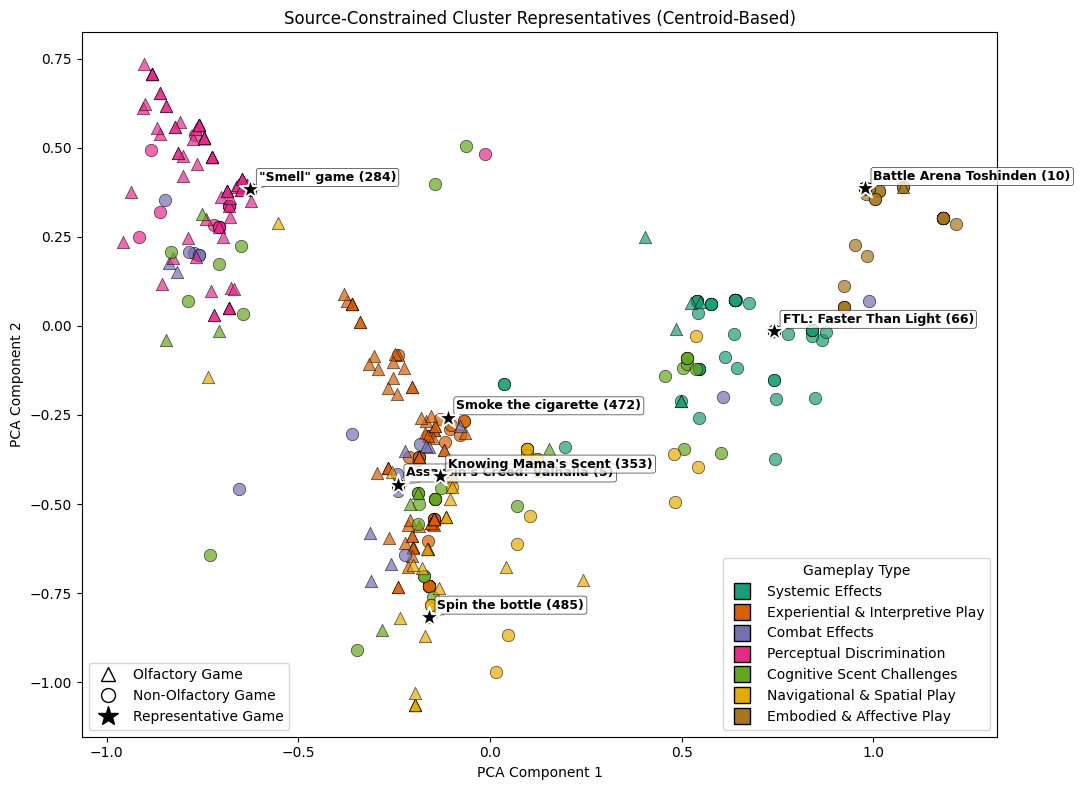

Centroid-based representative game per cluster (source-constrained):
Systemic Effects: FTL: Faster Than Light (66)
Experiential & Interpretive Play: Smoke the cigarette (472)
Combat Effects: Assassin's Creed: Valhalla (5)
Perceptual Discrimination: "Smell" game (284)
Cognitive Scent Challenges: Knowing Mama's Scent (353)
Navigational & Spatial Play: Spin the bottle (485)
Embodied & Affective Play: Battle Arena Toshinden (10)


In [24]:
# --- 6. Compute Closest Representative per Cluster (with Source Constraint) ---

olfactory_clusters = {1, 3, 4, 5}
non_olfactory_clusters = {0, 2}

excluded_titles = {"Guessing Jar (341)"}
closest_games_source_constrained = {}

for cluster_id in range(n_clusters):
    preferred_source = 'Olfactory' if cluster_id in olfactory_clusters else 'Non-Olfactory'
    
    cluster_data = data[
        (data['Cluster'] == cluster_id) &
        (data['Source'] == preferred_source) &
        (~data['Game Title'].isin(excluded_titles))
    ]
    
    if cluster_data.empty:
        print(f"Warning: No {preferred_source} game (excluding excluded titles) found for Cluster {cluster_id}. Using any available game.")
        cluster_data = data[
            (data['Cluster'] == cluster_id) &
            (~data['Game Title'].isin(excluded_titles))
        ]

    cluster_points = pca_features[cluster_data.index]
    centroid = cluster_points.mean(axis=0)
    
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    closest_idx = cluster_data.index[np.argmin(distances)]
    closest_games_source_constrained[cluster_id] = data.loc[closest_idx, 'Game Title']


# --- 7. Prepare DataFrame for Plotting ---
representative_games = pd.DataFrame([
    {
        'Cluster': cluster_id,
        'Game Title': game_title,
        'PCA1': data.loc[data['Game Title'] == game_title, 'PCA1'].values[0],
        'PCA2': data.loc[data['Game Title'] == game_title, 'PCA2'].values[0]
    }
    for cluster_id, game_title in closest_games_source_constrained.items()
])

# --- 8. Plot PCA with Source-Constrained Centroid Representatives Highlighted ---
fig, ax = plt.subplots(figsize=(11, 8))

# Plot all games
for cluster_id in range(n_clusters):
    for source, marker in zip(['Non-Olfactory', 'Olfactory'], ['o', '^']):
        subset = data[(data['Cluster'] == cluster_id) & (data['Source'] == source)]
        ax.scatter(
            subset['PCA1'], subset['PCA2'],
            color=cluster_palette[cluster_id],
            marker=marker, s=80, alpha=0.7,
            edgecolor='black', linewidth=0.5
        )

# Plot and annotate representative games
for _, row in representative_games.iterrows():
    ax.scatter(
        row['PCA1'], row['PCA2'],
        color='black', marker='*', s=250,
        edgecolor='white', linewidth=1.5, zorder=5
    )
    ax.annotate(
        row['Game Title'],
        (row['PCA1'], row['PCA2']),
        textcoords="offset points",
        xytext=(6, 6),
        ha='left',
        fontsize=9,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', lw=0.5, alpha=0.8),
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
    )

# --- Legends ---
from matplotlib.lines import Line2D
source_legend = [
    Line2D([0], [0], marker='^', color='black', label='Olfactory Game', linestyle='', markerfacecolor='white', markersize=10),
    Line2D([0], [0], marker='o', color='black', label='Non-Olfactory Game', linestyle='', markerfacecolor='white', markersize=10),
    Line2D([0], [0], marker='*', color='black', label='Representative Game', linestyle='', markerfacecolor='black', markersize=15)
]
cluster_legend = [
    Line2D([0], [0], marker='s', color='black', linestyle='', markerfacecolor=color, markersize=12, label=name)
    for color, name in zip(cluster_palette, cluster_names)
]
legend1 = ax.legend(handles=source_legend, loc='lower left', frameon=True)
legend2 = ax.legend(handles=cluster_legend, title='Gameplay Type', loc='lower right', frameon=True)
ax.add_artist(legend1)

# --- Final Touches ---
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('Source-Constrained Cluster Representatives (Centroid-Based)')
plt.tight_layout()
plt.savefig('./Plots/Figure09_PCA-Clustering.png')
plt.show()

# --- Print Summary ---
print("Centroid-based representative game per cluster (source-constrained):")
for cluster_id, game_title in closest_games_source_constrained.items():
    cluster_name = cluster_names[cluster_id] if cluster_id < len(cluster_names) else f"Cluster {cluster_id}"
    print(f"{cluster_name}: {game_title}")


**Figure 9: Mapping the landscape of olfactory game mechanics.** This PCA plot visualizes 529 games based on their mechanical profiles, with colors indicating cluster membership and shapes denoting game type.

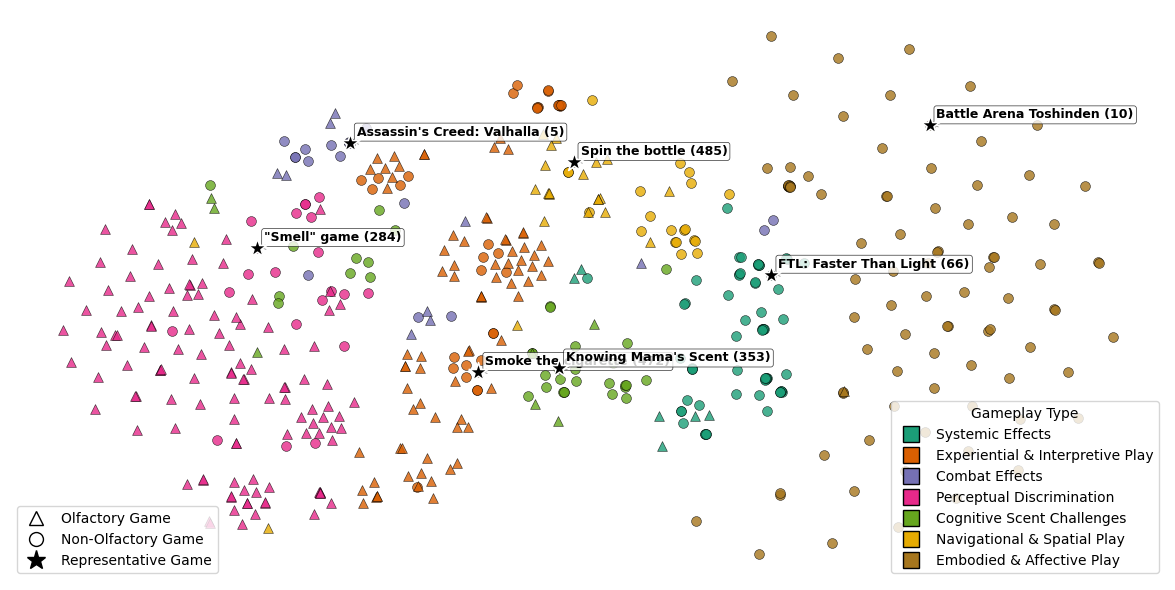

In [25]:
from sklearn.manifold import TSNE

# --- Apply t-SNE on PCA-reduced data ---
tsne = TSNE(n_components=2, random_state=41, perplexity=35)
tsne_results = tsne.fit_transform(game_embeddings_pca[:, :n_components_90])

# Prepare data
data_tsne = data.copy()
data_tsne['TSNE1'] = tsne_results[:, 0]
data_tsne['TSNE2'] = tsne_results[:, 1]

# --- Add slight jitter for better visual separation ---
jitter_strength = 0.2  # Adjust as needed
data_tsne['TSNE1_jitter'] = data_tsne['TSNE1'] + np.random.normal(0, jitter_strength, size=len(data_tsne))
data_tsne['TSNE2_jitter'] = data_tsne['TSNE2'] + np.random.normal(0, jitter_strength, size=len(data_tsne))

# --- Stylized t-SNE Plot with Source-Constrained Representatives (Centroid-Based) ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all games by cluster and source
for cluster_id in range(n_clusters):
    for source, marker in zip(['Non-Olfactory', 'Olfactory'], ['o', '^']):
        subset = data_tsne[(data_tsne['Cluster'] == cluster_id) & (data_tsne['Source'] == source)]
        ax.scatter(
            subset['TSNE1_jitter'], subset['TSNE2_jitter'],
            color=cluster_palette[cluster_id],
            marker=marker, s=50, alpha=0.8,
            edgecolor='black', linewidth=0.4
        )

# --- Highlight Centroid-Based Representatives ---
for cluster_id, game_title in closest_games_source_constrained.items():
    tsne_row = data_tsne[data_tsne['Game Title'] == game_title]
    if not tsne_row.empty:
        x, y = tsne_row.iloc[0][['TSNE1_jitter', 'TSNE2_jitter']]
        ax.scatter(
            x, y, color='black', marker='*', s=200,
            edgecolor='white', linewidth=1.2, zorder=5
        )
        ax.annotate(
            game_title,
            (x, y),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left',
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='black', lw=0.5, alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
        )

# --- Legends ---
from matplotlib.lines import Line2D
source_legend = [
    Line2D([0], [0], marker='^', color='black', label='Olfactory Game', linestyle='', markerfacecolor='white', markersize=10),
    Line2D([0], [0], marker='o', color='black', label='Non-Olfactory Game', linestyle='', markerfacecolor='white', markersize=10),
    Line2D([0], [0], marker='*', color='black', label='Representative Game', linestyle='', markerfacecolor='black', markersize=14)
]
cluster_legend = [
    Line2D([0], [0], marker='s', color='black', linestyle='', markerfacecolor=color, markersize=12, label=name)
    for color, name in zip(cluster_palette, cluster_names)
]
legend1 = ax.legend(handles=source_legend, loc='lower left', frameon=True)
legend2 = ax.legend(handles=cluster_legend, title='Gameplay Type', loc='lower right', frameon=True)
ax.add_artist(legend1)

# --- Aesthetic Touches ---
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title('')
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'  # ensures text remains as text in SVG
plt.savefig('./Plots/Figure01_TSNE-Clustering.png')
plt.show()


**Figure 1: t-SNE projection of 529 games in smell-based mechanic space, colored by cluster.** Games closer together tend to share similar sets of mechanics. Shapes distinguish olfactory (▲) and non-olfactory (●) games. Centroid games for each cluster that had visual documentation are presented around the edge, showcasing diversity in mechanic usage and interaction design.

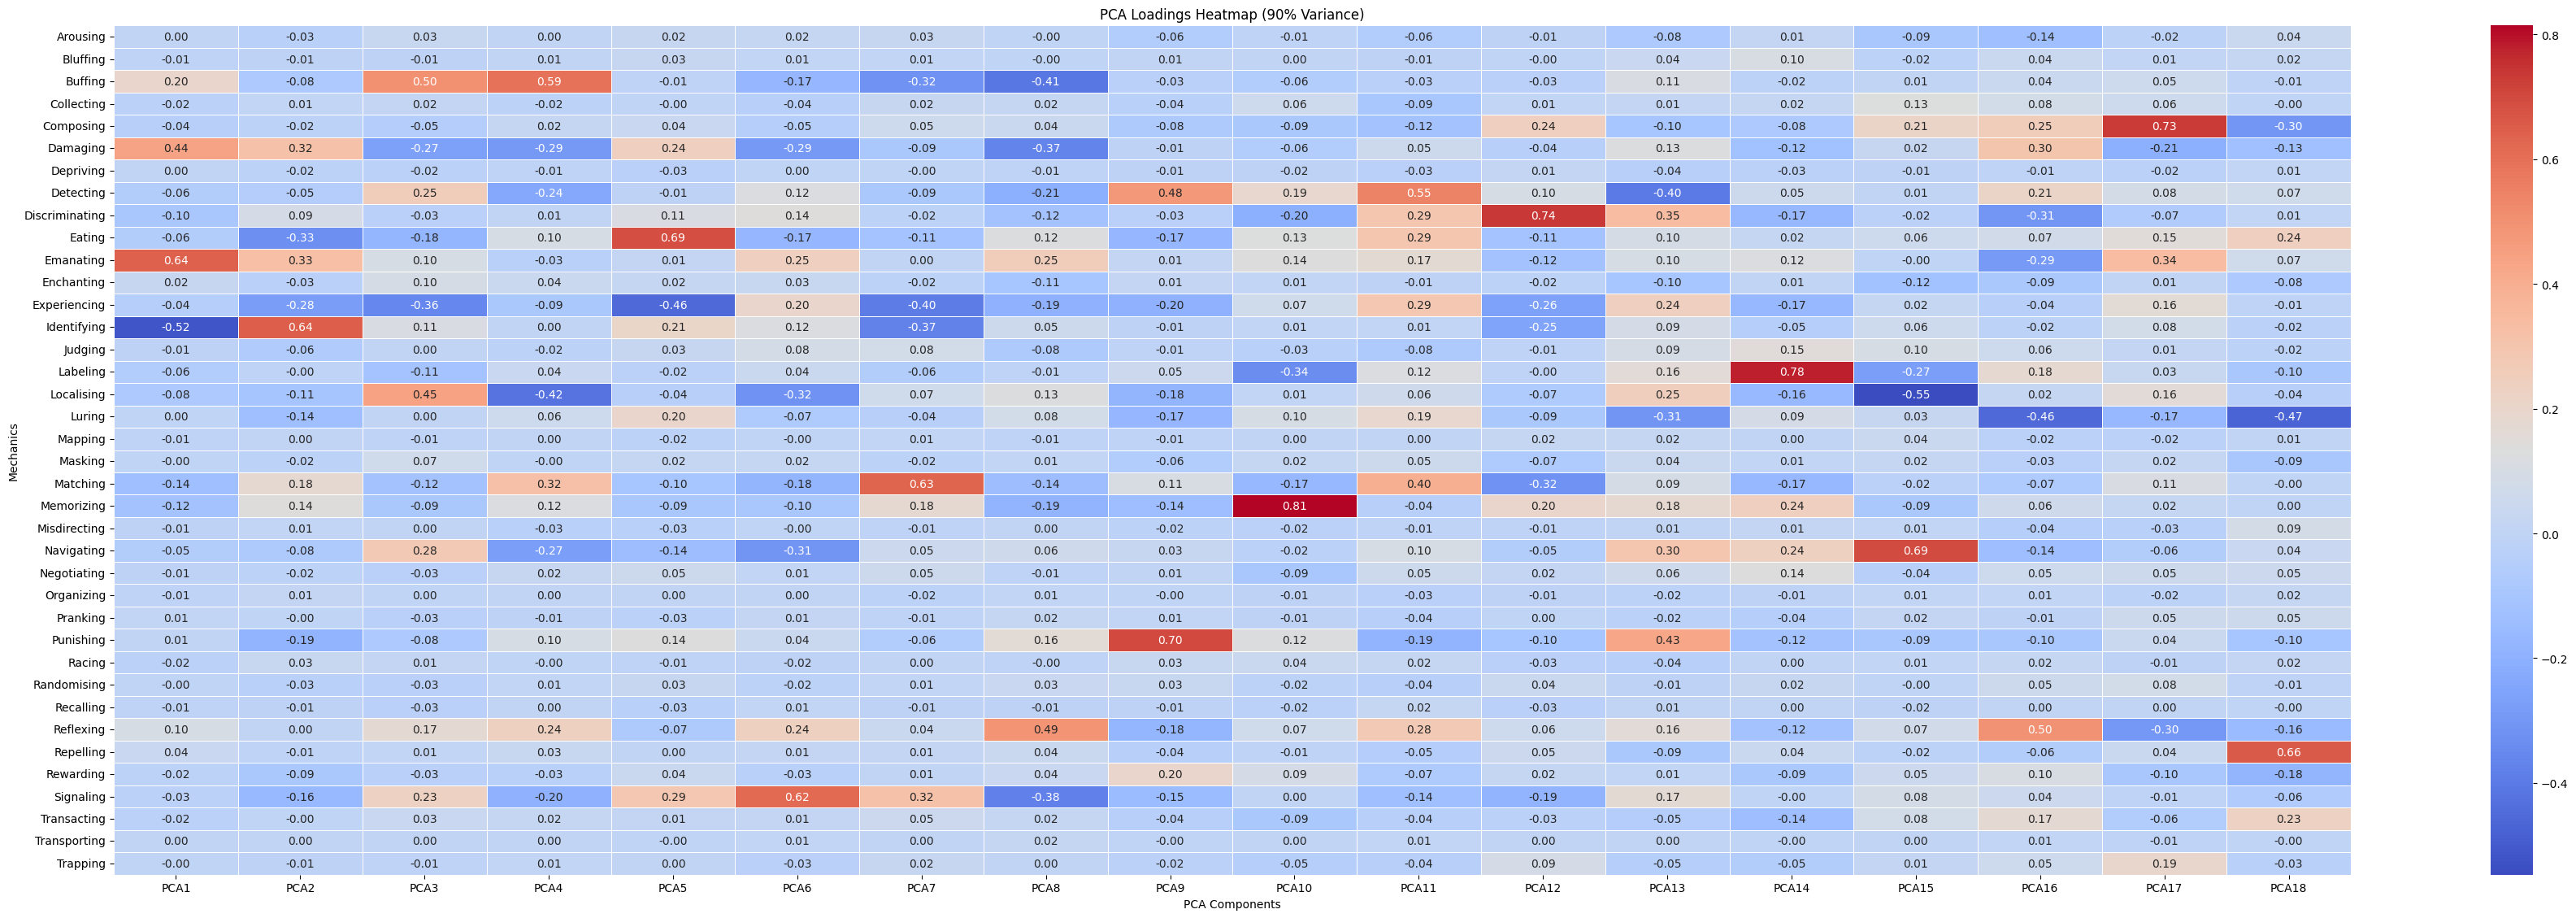

In [26]:
# --- 6. PCA Loadings Heatmap ---
loading_matrix = pd.DataFrame(
    pca.components_[:n_components_90].T,
    columns=[f'PCA{i+1}' for i in range(n_components_90)],
    index=all_mechanics
)
loading_matrix.to_csv('./Data/PCA_Loadings.csv')

plt.figure(figsize=(n_components_90 * 2, len(all_mechanics) * 0.3))
sns.heatmap(loading_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.xlabel("PCA Components")
plt.ylabel("Mechanics")
plt.title("PCA Loadings Heatmap (90% Variance)")
plt.tight_layout()
plt.savefig('./Plots/PCA_Loadings_Heatmap.png')
plt.show()

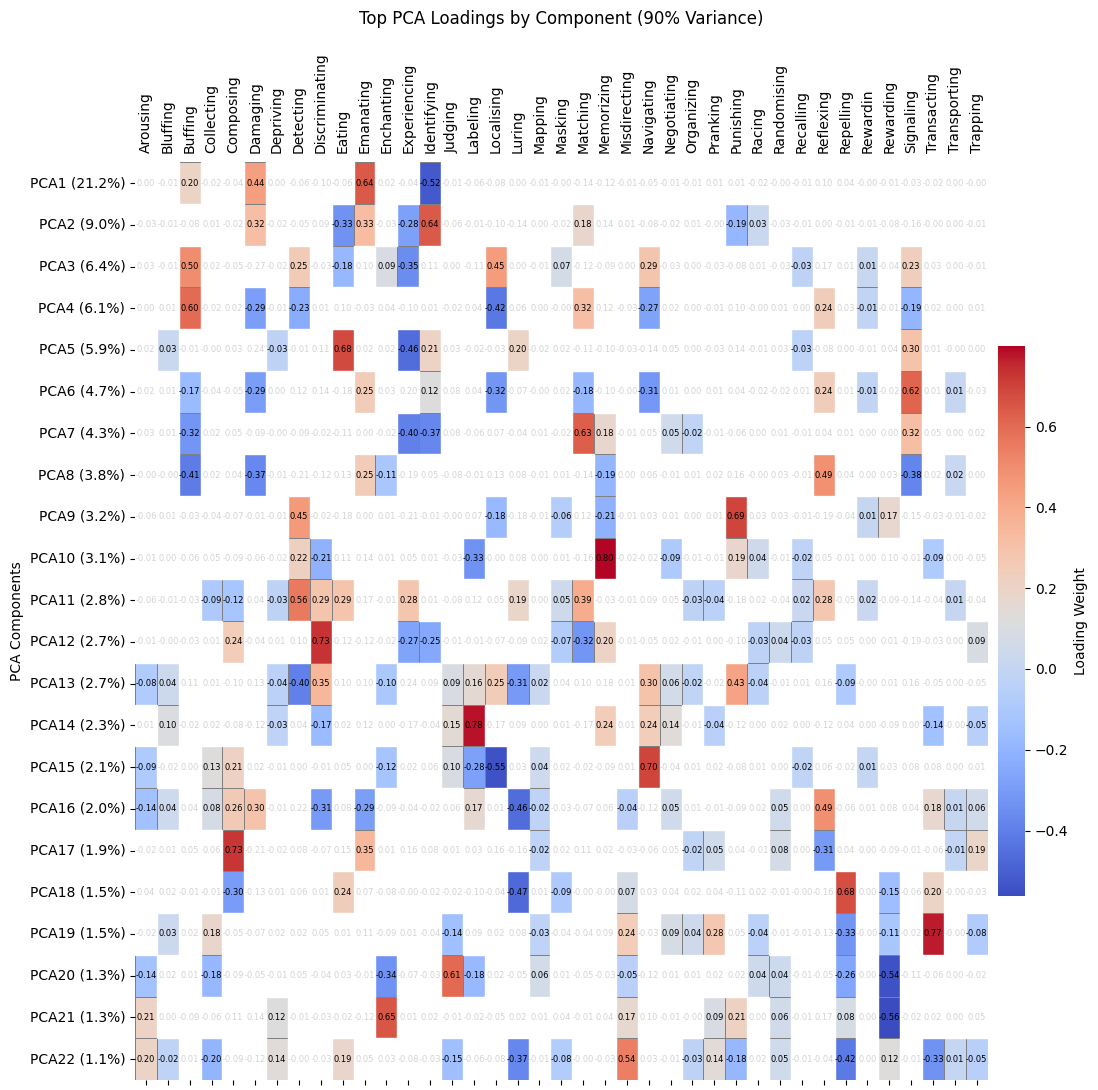

In [92]:
# --- Compute % variance explained ---
explained_variance = pca.explained_variance_ratio_[:n_components_90] * 100
component_labels = [f'PCA{i+1} ({v:.1f}%)' for i, v in enumerate(explained_variance)]

# --- Set up loading matrix ---
loading_display = loading_matrix.iloc[:, :n_components_90].T
loading_display.index = component_labels

# --- Prepare mask for top-k highlighting ---
top_k = 6
is_top = pd.DataFrame(False, index=loading_display.index, columns=loading_display.columns)
for col in loading_display.columns:
    top_indices = loading_display[col].abs().nlargest(top_k).index
    is_top.loc[top_indices, col] = True

# --- Create figure and axis ---
fig, ax = plt.subplots(figsize=(len(loading_display.columns) * 0.3, len(loading_display.index) * 0.5))

# Draw the heatmap
sns.heatmap(
    loading_display,
    cmap='coolwarm',
    fmt='',
    annot=False,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Loading Weight', 'shrink': 0.6, 'pad': 0.01},
    ax=ax
)

# Overlay custom text annotations
for i in range(loading_display.shape[0]):  # rows (PCA components)
    for j in range(loading_display.shape[1]):  # columns (mechanics)
        value = loading_display.iloc[i, j]
        if pd.notna(value):
            if is_top.iloc[i, j]:
                ax.text(j + 0.5, i + 0.5, f'{value:.2f}',
                        ha='center', va='center', color='black', fontsize=6)
            else:
                # White background with light gray text
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='white', zorder=2))
                ax.text(j + 0.5, i + 0.5, f'{value:.2f}',
                        ha='center', va='center', color='lightgray', fontsize=6, zorder=3)

# --- Label formatting ---
ax.set_xlabel("")
ax.set_ylabel("PCA Components")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.tick_params(axis='x', labeltop=True, labelbottom=False)

# --- Title and layout ---
plt.title("Top PCA Loadings by Component (90% Variance)", pad=20)
plt.tight_layout()
plt.savefig('./Plots/PCA_Loadings_Top5_WhiteMask.png', dpi=300)
plt.show()
